# 1 Columns - Definition

The time period for this data is between Jan 1st, 2010 to Dec 31st, 2015. Missing data are denoted as NA.

No: row number

year: year of data in this row

month: month of data in this row

day: day of data in this row

hour: hour of data in this row

season: season of data in this row

PM: PM2.5 concentration (ug/m^3)

DEWP: Dew Point (Celsius Degree)

TEMP: Temperature (Celsius Degree)

HUMI: Humidity (%)

PRES: Pressure (hPa)

cbwd: Combined wind direction

Iws: Cumulated wind speed (m/s)

precipitation: hourly precipitation (mm)

Iprec: Cumulated precipitation (mm)

# 2 Load and prepare the data

### 2.1 Import Package

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.externals import joblib
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [3]:
%pwd

'C:\\Users\\carri\\Jupyter\\NEU-6105 Data Sci Eng Methods\\Project'

In [4]:
my_path='C:\\Users\\carri\\Jupyter\\NEU-6105 Data Sci Eng Methods\\Project'

In [5]:
df = pd.read_csv(f'{my_path}/Raw/BeijingPM20100101_20151231.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 18 columns):
No                 52584 non-null int64
year               52584 non-null int64
month              52584 non-null int64
day                52584 non-null int64
hour               52584 non-null int64
season             52584 non-null int64
PM_Dongsi          25052 non-null float64
PM_Dongsihuan      20508 non-null float64
PM_Nongzhanguan    24931 non-null float64
PM_US Post         50387 non-null float64
DEWP               52579 non-null float64
HUMI               52245 non-null float64
PRES               52245 non-null float64
TEMP               52579 non-null float64
cbwd               52579 non-null object
Iws                52579 non-null float64
precipitation      52100 non-null float64
Iprec              52100 non-null float64
dtypes: float64(11), int64(6), object(1)
memory usage: 7.2+ MB


In [7]:
df.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


### 2.2 Drop Rows and Columns

In [8]:
# change "cv"" in cbwd to "SW"
df['cbwd'] = df['cbwd'].replace('cv', 'SW')
df.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


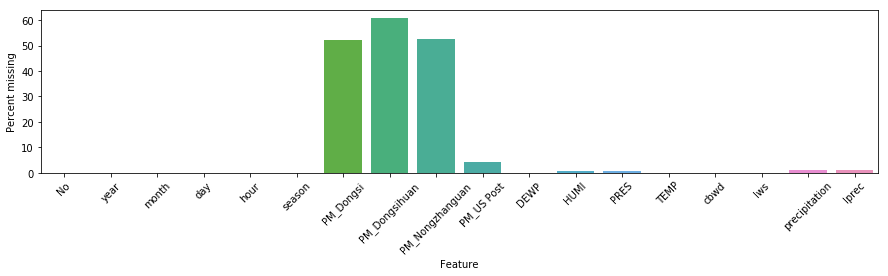

In [9]:
null_vals = df.isnull().sum()/len(df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (15,3))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [10]:
# drop the largest amount of null column among 3 PM locations 
df = df.drop(["No","PM_Nongzhanguan","PM_Dongsihuan"],axis = 1)

In [11]:
# drop any rows with null value
df=df.dropna(axis=0, how="any")

In [12]:
# print(df.isnull().sum())

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23951 entries, 26694 to 52582
Data columns (total 15 columns):
year             23951 non-null int64
month            23951 non-null int64
day              23951 non-null int64
hour             23951 non-null int64
season           23951 non-null int64
PM_Dongsi        23951 non-null float64
PM_US Post       23951 non-null float64
DEWP             23951 non-null float64
HUMI             23951 non-null float64
PRES             23951 non-null float64
TEMP             23951 non-null float64
cbwd             23951 non-null object
Iws              23951 non-null float64
precipitation    23951 non-null float64
Iprec            23951 non-null float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.9+ MB


### 2.3 Encoding Categorical Features

In [14]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df["cbwd"] = enc.fit_transform(df["cbwd"])

In [15]:
df.head()

,year,month,day,hour,season,PM_Dongsi,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
26694,2013,1,17,6,4,25.0,34.0,-17.0,56.0,1038.0,-10.0,1,4.92,0.0,0.0
26695,2013,1,17,7,4,22.0,33.0,-16.0,52.0,1039.0,-8.0,0,4.92,0.0,0.0
26696,2013,1,17,8,4,20.0,33.0,-16.0,45.0,1040.0,-6.0,0,8.94,0.0,0.0
26697,2013,1,17,9,4,24.0,34.0,-16.0,38.0,1040.0,-4.0,0,12.07,0.0,0.0
26698,2013,1,17,10,4,27.0,38.0,-16.0,35.0,1040.0,-3.0,0,16.09,0.0,0.0


In [16]:
# categorize the PM 2.5 into 6 categories
#    PM 2.5    -    Category
#   [0, 35]            1
#   (35, 75]           2
#  (75, 115]           3
# (115, 150]           4
# (150, 250]           5
# (250 -               6
df["PM_US Post"] = pd.cut(df["PM_US Post"],[-1,35,75,115,150,250,float("inf")],labels=[1,2,3,4,5,6])
df["PM_Dongsi"] = pd.cut(df["PM_Dongsi"],[-1,35,75,115,150,250,float("inf")],labels=[1,2,3,4,5,6])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23951 entries, 26694 to 52582
Data columns (total 15 columns):
year             23951 non-null int64
month            23951 non-null int64
day              23951 non-null int64
hour             23951 non-null int64
season           23951 non-null int64
PM_Dongsi        23951 non-null category
PM_US Post       23951 non-null category
DEWP             23951 non-null float64
HUMI             23951 non-null float64
PRES             23951 non-null float64
TEMP             23951 non-null float64
cbwd             23951 non-null int32
Iws              23951 non-null float64
precipitation    23951 non-null float64
Iprec            23951 non-null float64
dtypes: category(2), float64(7), int32(1), int64(5)
memory usage: 2.5 MB


In [18]:
print(df.PM_Dongsi.cat.categories)

Int64Index([1, 2, 3, 4, 5, 6], dtype='int64')


In [19]:
df['PM_Dongsi']= df['PM_Dongsi'].astype('int64')
df['PM_US Post']= df['PM_US Post'].astype('int64')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23951 entries, 26694 to 52582
Data columns (total 15 columns):
year             23951 non-null int64
month            23951 non-null int64
day              23951 non-null int64
hour             23951 non-null int64
season           23951 non-null int64
PM_Dongsi        23951 non-null int64
PM_US Post       23951 non-null int64
DEWP             23951 non-null float64
HUMI             23951 non-null float64
PRES             23951 non-null float64
TEMP             23951 non-null float64
cbwd             23951 non-null int32
Iws              23951 non-null float64
precipitation    23951 non-null float64
Iprec            23951 non-null float64
dtypes: float64(7), int32(1), int64(7)
memory usage: 2.8 MB


In [21]:
df.head()

,year,month,day,hour,season,PM_Dongsi,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
26694,2013,1,17,6,4,1,1,-17.0,56.0,1038.0,-10.0,1,4.92,0.0,0.0
26695,2013,1,17,7,4,1,1,-16.0,52.0,1039.0,-8.0,0,4.92,0.0,0.0
26696,2013,1,17,8,4,1,1,-16.0,45.0,1040.0,-6.0,0,8.94,0.0,0.0
26697,2013,1,17,9,4,1,1,-16.0,38.0,1040.0,-4.0,0,12.07,0.0,0.0
26698,2013,1,17,10,4,1,2,-16.0,35.0,1040.0,-3.0,0,16.09,0.0,0.0


### 2.4 Corelation plot

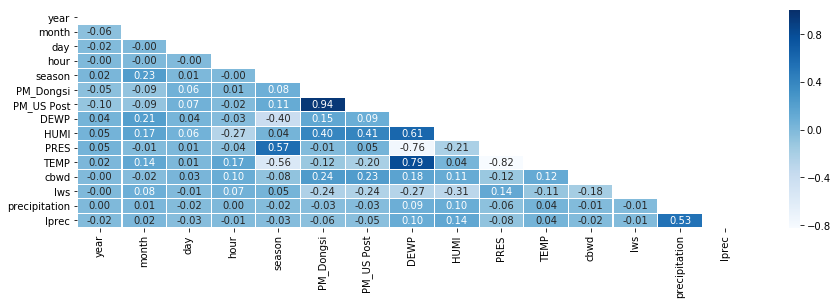

In [22]:
fig,ax = plt.subplots(figsize=(15,4))
mask=np.zeros_like(df.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(df.corr(),mask=mask,ax=ax,annot=True, linewidths=0.1, fmt='.2f',cmap="Blues")
plt.show()

PM_Dongsi, HUMI(Humidity), cbwd(Combined wind direction), lws(Cumulated wind speed) and TEMP(Temperature) are important to the result of PM_US Post

### 2.5 Converting the data to X and Y

In [23]:
Y = df["PM_US Post"]
X = df.drop("PM_US Post", axis=1)

### 2.6 Splitting the data into train, validation and test sets

In [24]:
from sklearn.model_selection import train_test_split
X_train_val,X_test,Y_train_val,Y_test = train_test_split(X,Y,test_size = 0.12, random_state=666)
print(X_train_val.shape, Y_train_val.shape, X_test.shape, Y_test.shape)

(21076, 14) (21076,) (2875, 14) (2875,)


### 2.7 Feature Selection

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [26]:
clf=ExtraTreesClassifier()
clf=clf.fit(X_train_val,Y_train_val)
clf.feature_importances_

array([0.0315045 , 0.03587762, 0.06258697, 0.06065158, 0.0162508 ,
       0.39268739, 0.07354861, 0.07657473, 0.06378062, 0.06036988,
       0.04853564, 0.06722426, 0.00466062, 0.00574678])

In [27]:
model=SelectFromModel(clf,threshold=0.05,prefit=True)
X_train_val_reduction=model.transform(X_train_val)
feature_idx=model.get_support()
feature_name=X_train_val.columns[feature_idx]

In [28]:
print(feature_name)

Index(['day', 'hour', 'PM_Dongsi', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws'], dtype='object')


In [29]:
X_fs = df[list(feature_name)]
X_train_val_fs,X_test_fs,Y_train_val,Y_test = train_test_split(X,Y,test_size = 0.12, random_state=666)
print(X_train_val_fs.shape, Y_train_val.shape, X_test_fs.shape, Y_test.shape)

(21076, 14) (21076,) (2875, 14) (2875,)


In [30]:
X_train_fs,X_val_fs,Y_train,Y_val = train_test_split(X_train_val_fs,Y_train_val,test_size = 0.14, random_state=666)
print(X_train_fs.shape, Y_train.shape, X_val_fs.shape, Y_val.shape)

(18125, 14) (18125,) (2951, 14) (2951,)


# 3 Model Selection

### 3.1 Function Definition

In [31]:
def model_selection(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train,y_train)
    y_test_pred=clf.predict(x_test)
    score=clf.score(x_test,y_test)
    r2=r2_score(y_test,y_test_pred)
    print("Score is " + str(score))
    print("r**2 score is " + str(r2))

### 3.2 KNN

In [32]:
from sklearn import neighbors
from sklearn.metrics import r2_score
KNN_clf = KNeighborsClassifier()

In [33]:
model_selection(KNN_clf, X_train_fs, Y_train,X_test_fs,Y_test)

Score is 0.5826086956521739
r**2 score is 0.5214077921402362


##### 3.2.1 KNN GridSearch

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
param_grid = [
    {
    'weights':['uniform'],
    'n_neighbors':[i for i in range(1,10)],
    },
    {
    'weights':['distance'],
    'n_neighbors':[i for i in range(1,10)],
    'p':[i for i in range(1,3)]
    }
]

In [36]:
KNN_clf_grid = KNeighborsClassifier()

In [37]:
grid_search = GridSearchCV(KNN_clf_grid, param_grid=param_grid,n_jobs=-1)

In [38]:
grid_search.fit(X_train_fs,Y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'weights': ['uniform'], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]}, {'weights': ['distance'], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'p': [1, 2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
grid_search.best_params_

{'n_neighbors': 1, 'p': 1, 'weights': 'distance'}

In [40]:
best_knn_clf=grid_search.best_estimator_
model_selection(best_knn_clf, X_train_fs, Y_train,X_test_fs,Y_test)

Score is 0.7182608695652174
r**2 score is 0.7930588732471986


### 3.3 Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
rf_clf=RandomForestClassifier(oob_score=False,bootstrap=True,random_state=666,n_jobs=-1)
model_selection(rf_clf,X_train_fs, Y_train,X_test_fs,Y_test)

Score is 0.7801739130434783
r**2 score is 0.8865288073143198


##### 3.3.1 Random Forest GridSearch

In [43]:
param_grid = [
    {
        'max_depth': [i for i in range(1,4)],
        'n_estimators': [i for i in range(80,130)],
        'class_weight': ["balanced"],
        'bootstrap': [True]
    }
]

In [44]:
rf_clf_grid = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf_clf_grid,param_grid,cv=3,n_jobs=-1)
grid_search_rf.fit(X_train_fs,Y_train.tolist())

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_depth': [1, 2, 3], 'n_estimators': [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129], 'class_weight': ['balanced'], 'bootstrap': [True]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
best_rf_clf=grid_search_rf.best_estimator_
model_selection(best_rf_clf,X_train_fs, Y_train,X_test_fs,Y_test)

Score is 0.6740869565217391
r**2 score is 0.7193287434376092


### 3.4 Gradient Boosting

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [47]:
gb_clf = GradientBoostingClassifier(max_depth= 5, n_estimators=30)
gb_clf.fit(X_train_fs,Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [48]:
model_selection(gb_clf, X_train_fs, Y_train,X_test_fs,Y_test)

Score is 0.7652173913043478
r**2 score is 0.8857444442312391


##### 3.4.1 Gradient Boosting GridSearch

In [49]:
param_grid = [
    {
        'max_features': [i for i in range(1,4)],
        'max_depth': [i for i in range(1,4)],
        'n_estimators':[i for i in range(1,30)]
    }
]

In [50]:
gb_clf_grid = GradientBoostingClassifier()
grid_search_gb = GridSearchCV(gb_clf_grid,param_grid,cv=3,n_jobs=-1)
grid_search_gb.fit(X_train_fs,Y_train.tolist())

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'max_features': [1, 2, 3], 'max_depth': [1, 2, 3], 'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [51]:
grid_search_gb.best_params_

{'max_depth': 3, 'max_features': 3, 'n_estimators': 28}

In [52]:
best_gd_clf=grid_search_gb.best_estimator_
model_selection(best_gd_clf, X_train_fs, Y_train,X_test_fs,Y_test)

Score is 0.7544347826086957
r**2 score is 0.874240452346055
